# Imports

In [0]:
import pandas as pd
import folium  #needed for interactive map
from folium.plugins import HeatMap
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
  

# Google Drive authorization

In [0]:
# Google Drive imports and authorization

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Loading CSV files into pandas

In [0]:
# creating csv files within colab environment

file_list = drive.ListFile({'q': "'1sK4TQCIdr6pyrmCKrfDEv8Z4GcM-1jD-' in parents and trashed=false"}).GetList()
for file1 in [f for f in file_list if f['title'].endswith('.csv')]:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
    temp_file = drive.CreateFile({'id': file1['id']})
    temp_file.GetContentFile(file1['title'])

title: geographic.csv, id: 1Zaf48jT6RVJcteVKBkGLwRHRocnLiZZA
title: mta_trips.csv, id: 1h6cnlLbyS9oDkQxd0QITuDSfz2N2vkie
title: green_trips.csv, id: 1wB5xKwU3P7-ZdeXud6IXU54HUGInp7e_
title: yellow_trips.csv, id: 17PQgtknZXYTr52ifT4aST-Ak-fJ-cwvB
title: uber_trips_2014.csv, id: 1o9mGz9bSdFhcblfsnAHs3zBkI_2jyYBh
title: uber_trips_2015.csv, id: 1yX88JyAU3v8fy4yXXS4JTuVla2vWD1yW


In [0]:
mta_trips = pd.read_csv('mta_trips.csv')
uber_15 = pd.read_csv("uber_trips_2015.csv")
zones = pd.read_csv("zones.csv")
geographic = pd.read_csv("geographic.csv")
uber_14 = pd.read_csv("uber_trips_2014.csv")
weather = pd.read_csv("weather.csv")
demographics = pd.read_csv("demographics.csv")

# Cleaning geographic dataframe

In [0]:
numrows = geographic.shape[0]
numobvs = int(numrows / 2)
s = ['long', 'lat']
llcolumn = s*numobvs
len(llcolumn)

new_geographic = geographic.assign(LL= llcolumn)
geo_melt = new_geographic.melt(id_vars=['LL'])

numobvs2 = int(geographic.shape[0]*geographic.shape[1] / 2) 

obvslist = [item for item in range(numobvs2) for i in [0,1]]

new_geo_melt = geo_melt.assign(vertexNumber= obvslist)
new_geo_melt.columns = ["LL", "NTA", "value", "vertexNumber"]

geographic_clean = new_geo_melt.pivot_table('value', ['vertexNumber', "NTA"], 'LL') 
geographic_clean.head()


In [0]:
# Madison working on identifying NTA given (lat, long)

nta_min_max = geographic_clean.groupby("NTA").agg({"lat": ["min", "max"], "long":["min","max"]})
                          
nta_min_max.columns = ["latmin", "latmax", "longmin", "longmax"]
                                                   
# nta_min_max

mylat = 40.689136
mylong = -100



# nta_min_max.loc[(nta_min_max['latmin'] < mylat) & (nta_min_max['latmax'] > mylat) & (nta_min_max['longmin'] < mylong) & (nta_min_max['longmax'] > mylong)]

def getNTAfromLatLong(nta_min_max, mylat, mylong):
  result = nta_min_max.loc[(nta_min_max['latmin'] < mylat) & (nta_min_max['latmax'] > mylat) & (nta_min_max['longmin'] < mylong) & (nta_min_max['longmax'] > mylong)].index.values
  if result.shape[0]<1:
    return np.nan
  else:
    return result[0]
  
getNTAfromLatLong(nta_min_max, 40.689136, -74.001795)


getNTAfromLatLong(nta_min_max, mylat, mylong)




# Adding NTA to Uber 2015

In [0]:
uber_2015 = uber_15.merge(zones, how = "left", left_on = "pickup_location_id", right_on = "location_id")
uber_2015.head()

In [0]:
uber_2015new = uber_2015.merge(demographics, how = "left", left_on = "nta_code", right_on = "nta_code")

In [0]:
nta1 = uber_2015new.groupby('nta_name')["pickup_datetime"].count().rename("trips").reset_index()

In [0]:
demo = demographics.merge(nta1, how = "left", left_on = "nta_name", right_on = "nta_name")

In [0]:
demo

In [0]:
#mask = (demo['median_income'] > 100000)
#high_income = demo[mask]

In [0]:
#uber_14.head()

In [0]:
#uber_14['NTA'] = uber_14.apply(lambda x: getNTAfromLatLong(nta_min_max, x['pickup_latitude'], x['pickup_longitude']), axis=1)

#uber_14.isna().any()

In [0]:
#uber_14.columns

# Misc 

In [0]:
# testing try again to see if it refreshes

In [0]:
geographic.dropna()
polygons = geographic.to_dict('list')

import numbers

for k, v in polygons.items():
    polygons[k] = [i for i in v if str(i) != 'nan']

for key in polygons:
    it = iter(polygons[key])
    tuples = list(zip(it, it))
    polygons.update({key: tuples})
    
print(polygons['QN29'])

In [0]:
# Testing Even-Odd Rule for polygon problem

def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                  (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [0]:
sample = uber_14.head(10)

nta_code = []
for idx,row in sample.iterrows():
    x = row["pickup_longitude"]
    y = row["pickup_latitude"]
    #print(idx,x,y)
    for poly in polygons:
        nta = 0
        lat_long_check = is_point_in_path(x, y, polygons[poly])
        #print(lat_long_check)
        if lat_long_check != False: #WHY IS EVERYTHING FALSE?
            nta = poly
    nta_code.append(nta)

sample["nta_code"] = nta_code
sample

In [0]:
uber_2015.tail()

In [0]:
numrows = geographic.shape[1]
numobvs = numrows / 2
s = pd.Series(['long', 'lat'])
llcolumn = s.repeat(numobvs)
new_geographic = geographic.assign(address = ['Delhi', 'Bangalore', 'Chennai', 'Patna']) 

# Adding NTA codes to MTA data

In [0]:
mta_trips.head()

In [0]:
mta_station = mta_trips.groupby(by = "station").first()

#len(mta_trips["station"].unique()) #Should have 345 unique lat, long pairs 

mta_station.head()

In [0]:
getNTAfromLatLong(nta_min_max, 40.800605, -73.958158)

In [0]:
mta_station.dtypes

In [0]:
mta_station['NTA'] = mta_station.apply(lambda x: getNTAfromLatLong(nta_min_max, x['latitude'], x['longitude']), axis=1)

mta_station.isna().any()

In [0]:
np.sum(mta_station["NTA"].isna().values)

In [0]:
mta_withNTA = mta_trips.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

In [0]:
mta_withNTA.tail()

# Uber and MTA Demographics

                            OLS Regression Results                            
Dep. Variable:                  trips   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     36.10
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           2.45e-18
Time:                        20:43:56   Log-Likelihood:                -2490.1
No. Observations:                 185   AIC:                             4988.
Df Residuals:                     181   BIC:                             5001.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.027e+04   1.16e+05     

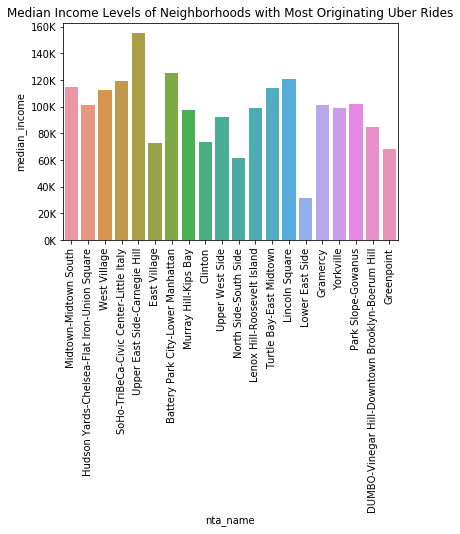

In [108]:
demo_sorted = demo.sort_values(by=['people_per_acre'], ascending=False)
demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

# xx = demo_sorted.head(5).plot.bar(x='nta_name', y='trips', rot=90)
# sns.barplot(x="nta_name", y="trips", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm


result = sm.ols(formula="trips ~ people_per_acre + median_age + median_income", data=demo_sorted).fit()
result.params
print(result.summary())
demo_sorted.head()
result.params


demo_sorted = demo.sort_values(by=['trips'], ascending=False)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with Most Originating Uber Rides")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.savefig('uberdemo1.png')

# demo_sorted.head(10)

# demo_sorted = demo.sort_values(by=['trips'], ascending=True)
# g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(10))
# plt.xticks(rotation=90)
# demo_sorted.head(10)


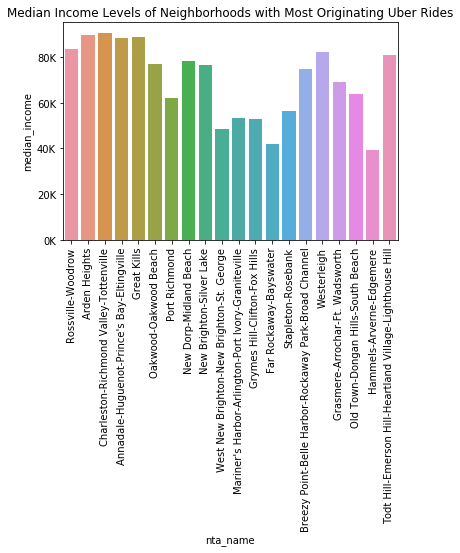

In [109]:
demo_sorted = demo.sort_values(by=['trips'], ascending=True)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with Fewest Originating Uber Rides")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.savefig('uberdemo2.png')

In [96]:
#demographics.shape
mta15demo.shape

(97, 37)

In [0]:
mta15demo.tail()

In [0]:
demo_sorted = demo.sort_values(by=['median_income'], ascending=False)
demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

xx = demo_sorted.head(5).plot.bar(x='nta_name', y='tripsperperson', rot=90)
sns.barplot(x="nta_name", y="tripsperperson", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm

result = sm.ols(formula="tripsperperson ~ median_income", data=demo_sorted).fit()
result.params
print(result.summary())

In [0]:
demo_sorted = demo.sort_values(by=['median_age'], ascending=True)
demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

xx = demo_sorted.head(5).plot.bar(x='nta_name', y='tripsperperson', rot=90)
sns.barplot(x="nta_name", y="tripsperperson", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm

result = sm.ols(formula="tripsperperson ~ median_age + median_income", data=demo_sorted).fit()
result.params
print(result.summary())


result = sm.ols(formula="trips ~ median_age + median_income", data=demo_sorted).fit()
result.params
print(result.summary())
result.params


In [0]:
mta15demo.columns

# MTA data

In [0]:
#mta_withNTA["year"] = 
mta_withNTA["datetime"].dtype

In [0]:
#NTA analysis for MTA 

mta_withNTA.groupby("NTA")

In [0]:
#uber_15 = pd.read_csv("uber_trips_2015.csv")
uber_2015.head()

date = []
hour = []
for i in uber_2015["pickup_datetime"]:
  s = str(i).split()
  date.append(s[0])
  hour.append(s[1])
  
uber_2015["date"] = date
uber_2015["hour"] = hour

In [0]:
month = []
day = []
year = []
for i in uber_2015["date"]:
  
  s = str(i).split("-")
  year.append(s[0])
  month.append(s[1])
  day.append(s[2])
  
uber_2015["month"] = month
uber_2015["day"] = day
uber_2015["year"] = year

In [0]:
uber_2015.head()

In [0]:
#month = []
#day = []
#year = []
date = []
hour = []
for i in mta_withNTA["datetime"]:
  s = str(i).split()
  date.append(s[0])
  hour.append(s[1])
  
mta_withNTA["date"] = date
mta_withNTA["hour"] = hour

In [0]:
month = []
day = []
year = []
for i in mta_withNTA["date"]:
  s = str(i).split("/")
  month.append(s[0])
  day.append(s[1])
  year.append(s[2])
  
mta_withNTA["month"] = month
mta_withNTA["day"] = day
mta_withNTA["year"] = year

In [0]:
is_2015 = mta_withNTA["year"] == '2015'
mta_2015 = mta_withNTA[is_2015]
mta_2015.head()

#mta_withNTA.head()

In [0]:
#is_2014 = mta_withNTA["year"] == '2014'
#mta_2014 = mta_withNTA[is_2014]
#mta_2014.head()

#mta_2014.to_csv('mta_2014.csv')
#from google.colab import files
#files.download('mta_2014.csv') 

mta_2015.to_csv('mta_2015.csv')
from google.colab import files
files.download('mta_2015.csv') 

In [0]:
#proportion of rows "lost"
(mta_withNTA.shape[0] - mta_2015.shape[0]) / mta_withNTA.shape[0] 
mta_2015["new_entries"].describe()

sub_2015 = mta_2015.groupby(["station","date"]).sum() #Get total entries per date for each station

#sub_2015 = sub_2015.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)
sub_2015.head()

#How many subway stations for each NTA? 

uberrides_perNTA = uber_2015.groupby("nta_code")["nta_code"].count()

np.sum(subways_perNTA)

#Yearly analysis of entries 

mta_peryear = mta_2015.groupby(["station", "year"]).sum()
mta_peryear = mta_peryear.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

#How many entries per NTA?

total_entries = mta_peryear.groupby("NTA").sum()

total_entries.head()

total_entries["new_entries"].describe()

In [0]:
# same but for uber 2015

rides_by_nta = uber_2015[["nta_code","date"]].groupby(["nta_code"])["date"].count().sort_values(ascending=False)
top_nta_uber = rides_by_nta.head(10)

#uber10_withinfo = top_nta_uber.merge(demographics, how = "left", left_on = "nta_code", right_on = "nta_code")

uber_ntas = top_nta_uber["nta_code"]
uber_rides = top_nta_uber["new_entries"]

plt.barh(uber_ntas, uber_rides, align='center', alpha=0.5)
plt.xlabel('Uber rides per year (in hundred millions)')
plt.ylabel("NTA")
plt.title('NTAs with the most uber rides per year')

plt.show()

In [0]:
sorted_TE = total_entries.sort_values("new_entries").tail(10)

top10_withinfo = sorted_TE.merge(demographics, how = "left", left_on = sorted_TE.index, right_on = "nta_code")


In [0]:
ntas = top10_withinfo["nta_name"]
new_entries = top10_withinfo["new_entries"]

plt.barh(ntas, new_entries, align='center', alpha=0.5)
plt.xlabel('Subway entries per year (in hundred millions)')
plt.ylabel("NTA")
plt.title('NTAs with the most subway entries per year')

plt.show()

In [0]:
mta_new = mta_withNTA.merge(demographics, how = "left", left_on = "NTA", right_on = "nta_code")
nta2 = mta_new.groupby('nta_name')["datetime_y"].count().rename("mta_trips").reset_index()

# Adding demographics to MTA 2015

In [0]:
mta_peryear = mta_2015.groupby(["station", "year"]).sum()
mta_peryear_2 = mta_peryear.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

#How many entries per NTA?

total_entries = mta_peryear_2.groupby("NTA").sum()

mta15demo = total_entries.merge(demographics, how = "left", left_on = "NTA", right_on = "nta_code")

mta15demo.columns

In [0]:
mta15demo.head()

# Time Analysis

In [0]:
# group MTA by month of year
mta_2015.head()
print(mta_2015.columns)
newentries_perNTApermonth = mta_2015.groupby(["NTA", "month"]).agg({"new_entries": ["sum"]})
newentries_perNTApermonth


In [0]:

#also group uber by month of yaer
uber_2015.head()
uber_withNTA_15only = uber_2015.query("year == '2015'")
uber_withNTA_15only = uber_withNTA_15only.dropna(subset=["nta_code"])
# uber_withNTA_15only.head()
print(uber_withNTA_15only.columns)
rides_perNTApermonth = uber_withNTA_15only.groupby(["nta_code", "month"]).agg({"pickup_datetime": ["count"]})

In [0]:
uberbymonth = rides_perNTApermonth.reset_index()
uberbymonth.columns = ["NTA", "Month", "Uber"]
uberbymonth
mtabymonth = newentries_perNTApermonth.reset_index()
mtabymonth.columns = ["NTA", "Month", "MTA"]
mtabymonth

# join all 
bymonth = uberbymonth.merge(mtabymonth, how = "outer", left_on = ["NTA", "Month"], right_on = ["NTA", "Month"])
# set NAN to 0, assume no rides happened if they weren't recorded 
bymonth = bymonth.fillna(0)
bymonth

timeresult = sm.ols(formula="Uber ~ MTA", data=bymonth).fit()
print(timeresult.summary())
timeresult.params
